In [20]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin

In [21]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [22]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r']
n_voxels = [0, 1, 100]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/630 [00:00<?, ?it/s]

In [23]:
pred = pd.concat(pred)
pdf = pd.concat(pdfs)
df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

In [27]:
import seaborn as sns

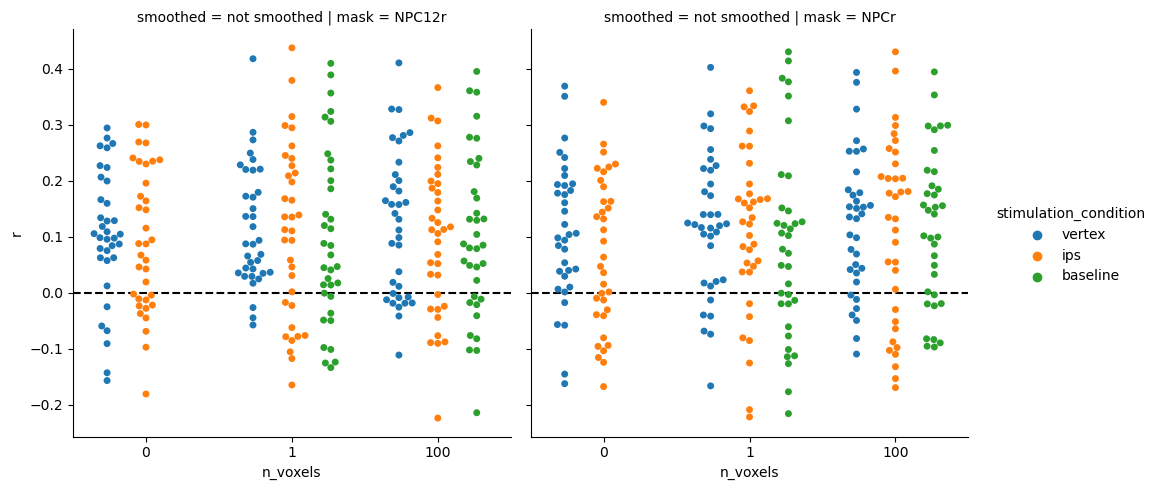

In [28]:
g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

In [29]:
palette = ['gray'] + sns.color_palette()[2:4]

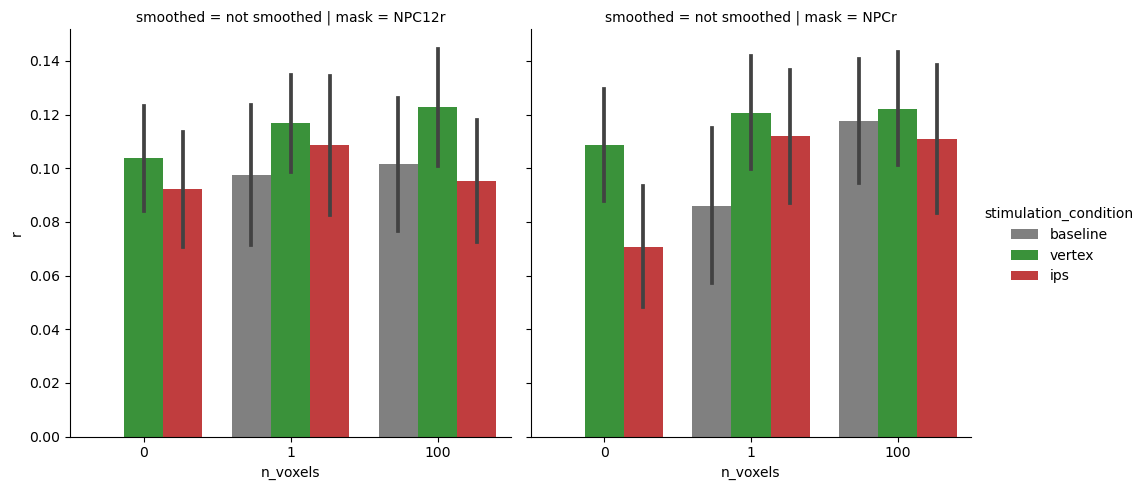

In [30]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, errorbar='se',
                  palette=palette)

In [32]:
r2.loc[18]

n  \
session stimulation_condition pca    glm     smoothed     mask   n_voxels         
1       baseline              no pca GLMstim not smoothed NPC12r 1         20.0   
                                                                 100       20.0   
                                                          NPCr   1         20.0   
                                                                 100       20.0   
2       ips                   no pca GLMstim not smoothed NPC12r 0         20.0   
                                                                 1         20.0   
                                                                 100       20.0   
                                                          NPCr   0         20.0   
                                                                 1         20.0   
                                                                 100       20.0   
3       vertex                no pca GLMstim not smoothed NPC12r 0         20.0   
                                                                 1         20.0   
                                                                 100       20.0   
                                                          NPCr   0         20.0   
                                                                 1         20.0   
                                                                 100       20.0   

                                                                                  r  \
session stimulation_condition pca    glm     smoothed     mask   n_voxels             
1       baseline              no pca GLMstim not smoothed NPC12r 1         0.313585   
                                                                 100       0.234156   
                                                          NPCr   1         0.376553   
                                                                 100       0.299134   
2       ips                   no pca GLMstim not smoothed NPC12r 0         0.267437   
                                                                 1         0.294496   
                                                                 100       0.311814   
                                                          NPCr   0         0.265372   
                                                                 1         0.333772   
                                                                 100       0.430232   
3       vertex                no pca GLMstim not smoothed NPC12r 0         0.159547   
                                                                 1         0.249392   
                                                                 100       0.285912   
                                                          NPCr   0         0.182469   
                                                                 1         0.226868   
                                                                 100       0.256644   

                                                                              p-val  \
session stimulation_condition pca    glm     smoothed     mask   n_voxels             
1       baseline              no pca GLMstim not smoothed NPC12r 1         0.271355   
                                                                 100       0.388354   
                                                          NPCr   1         0.192594   
                                                                 100       0.331552   
2       ips                   no pca GLMstim not smoothed NPC12r 0         0.321005   
                                                                 1         0.331184   
                                                                 100       0.244094   
                                                          NPCr   0         0.327306   
                                                                 1         0.241413   
                                                           

In [14]:
r2.drop('baseline', level='stimulation_condition').groupby(['n_voxels', 'mask']).apply(lambda d: pingouin.rm_anova(d.reset_index(), 'r', within='stimulation_condition', subject='subject'))

Source  ddof1  ddof2         F     p-unc  \
n_voxels mask                                                                
0        NPC12r 0  stimulation_condition      1     34  0.277797  0.601571   
         NPCr   0  stimulation_condition      1     34  2.208099  0.146502   
1        NPC12r 0  stimulation_condition      1     34  0.103049  0.750166   
         NPCr   0  stimulation_condition      1     34  0.109550  0.742688   
100      NPC12r 0  stimulation_condition      1     34  1.294639  0.263150   
         NPCr   0  stimulation_condition      1     34  0.151613  0.699427   

                        ng2  eps  
n_voxels mask                     
0        NPC12r 0  0.002353  1.0  
         NPCr   0  0.021852  1.0  
1        NPC12r 0  0.001024  1.0  
         NPCr   0  0.001095  1.0  
100      NPC12r 0  0.011101  1.0  
         NPCr   0  0.001539  1.0

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_66205/2504056157.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_pars = pred.groupby(['subject', 'stimulation_condition', 'n_voxels', 'mask']).mean()


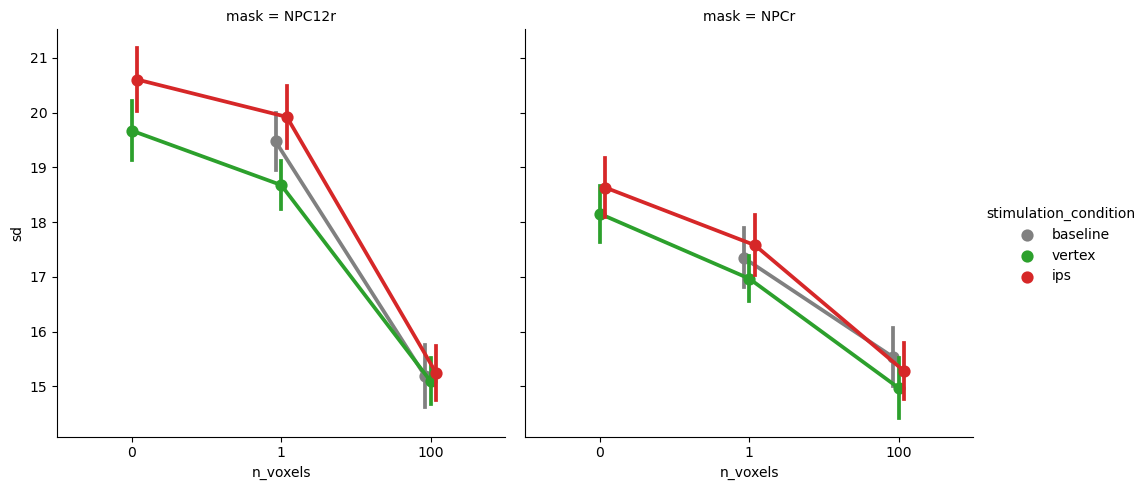

In [15]:
mean_pars = pred.groupby(['subject', 'stimulation_condition', 'n_voxels', 'mask']).mean()

sns.catplot(mean_pars.reset_index(), x='n_voxels', y='sd', hue='stimulation_condition', kind='point', col='mask', errorbar='se', dodge=True, palette=palette,
            hue_order=['baseline', 'vertex', 'ips'])

In [16]:
mean_pars.drop('baseline', level='stimulation_condition').groupby(['n_voxels', 'mask']).apply(lambda d: pingouin.rm_anova(d.reset_index(), 'sd', within='stimulation_condition', subject='subject'))

Source  ddof1  ddof2         F     p-unc  \
n_voxels mask                                                                
0        NPC12r 0  stimulation_condition      1     34  3.407541  0.073621   
         NPCr   0  stimulation_condition      1     34  0.786542  0.381378   
1        NPC12r 0  stimulation_condition      1     34  4.488021  0.041520   
         NPCr   0  stimulation_condition      1     34  1.010710  0.321834   
100      NPC12r 0  stimulation_condition      1     34  0.060596  0.807036   
         NPCr   0  stimulation_condition      1     34  0.197434  0.659616   

                        ng2  eps  
n_voxels mask                     
0        NPC12r 0  0.020001  1.0  
         NPCr   0  0.006042  1.0  
1        NPC12r 0  0.042170  1.0  
         NPCr   0  0.011661  1.0  
100      NPC12r 0  0.000772  1.0  
         NPCr   0  0.002452  1.0

In [17]:
bids_folder = '/data/ds-tmsrisk'
tms_subjects = [subject.subject for subject in get_subjects(bids_folder=bids_folder, all_tms_conditions=True)]
all_subjects = [subject.subject for subject in get_subjects(bids_folder=bids_folder, all_tms_conditions=False)]

no_tms_subjects = [sub for sub in all_subjects if sub not in tms_subjects]

In [18]:
no_tms_subjects

['08',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '20',
 '22',
 '23',
 '24',
 '27',
 '28',
 '32',
 '33',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '48',
 '49',
 '51',
 '52',
 '54',
 '55',
 '57',
 '58',
 '60',
 '61',
 '64',
 '65',
 '66',
 '68',
 '70',
 '71',
 '73',
 '75',
 '76',
 '77',
 '78']

In [ ]:
a